# Extended Essay - Rocket Launch Data Analysis

After integrating the rocket's position according to Newton's law of gravitational attraction, the results will be analyzed here.

In [2]:
import json
import spiceypy as sp
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.dates as pltdates
import matplotlib.colors as pltcolors
import math

In [3]:
def parse_body(name, results):
    data = results["bodies"][name]
    ephemerides = data["ephemerides"]
    time = np.array(results["time"], dtype=np.float)
    num_e = len(time)

    x = np.zeros(num_e)
    y = np.zeros(num_e)
    z = np.zeros(num_e)

    for i in range(num_e):
        x[i] = float(ephemerides[i * 3 + 0])
        y[i] = float(ephemerides[i * 3 + 1])
        z[i] = float(ephemerides[i * 3 + 2])
    
    return { "t": time, "x": x, "y": y, "z": z }

# project 3d points onto plane and convert to 2d
# S=(u v n) => S * x' = x => x' = transpose(S)*x
def project(x, y, z, u, n):
    az = n / np.linalg.norm(n)
    ax = np.cross(az, u)
    ax = ax / np.linalg.norm(ax)
    ay = np.cross(ax, az)

    S = np.array([ax, ay, az])
    transformed = [np.dot(S, np.array([_x, _y, _z])) for _x, _y, _z in zip(x, y, z)]
    resx = []
    resy = []
    for v in transformed:
        resx.append(v[0])
        resy.append(v[1])
    
    return resx, resy


In [4]:
# retrieve data
with open("../out/results.json") as file:
    results = json.load(file)

    # parse metadata
    gamma = float(results["metadata"]["gamma"])
    C3_e = results["metadata"]["C3_e"]
    C3_m = results["metadata"]["C3_m"]
    dv1 = results["metadata"]["dv1"]
    dv2 = results["metadata"]["dv2"]
    dv = results["metadata"]["dv"]
    phi = results["metadata"]["phi"]

    global porkchop
    porkchop = {
        "dt1": float(results["metadata"]["porkchop"]["dt1"]),
        "dt2": float(results["metadata"]["porkchop"]["dt2"]),
        "tof1": float(results["metadata"]["porkchop"]["tof1"]),
        "tof2": float(results["metadata"]["porkchop"]["tof2"]),
        "num_values": int(results["metadata"]["porkchop"]["num_values"]),
        "values": np.array([float(value) for value in results["porkchop"]["values"]])
    }

    global n_earth, n_mars
    n_earth_dict = results["metadata"]["n_earth"]
    n_earth = np.array([n_earth_dict["x"], n_earth_dict["y"], n_earth_dict["z"]])
    n_mars_dict = results["metadata"]["n_mars"]
    n_mars = np.array([n_mars_dict["x"], n_mars_dict["y"], n_mars_dict["z"]])

    print("Metadata:")
    print("----------------------------------")
    print(f"Step parameter (gamma): {gamma} Ns")
    print(f"Characteristic energy (C3,e): {C3_e * 1e-6} km^2/s^2")
    print(f"Specific asymptotic exit energy (C3,m): {C3_m * 1e-6} km^2/s^2")
    print(f"Delta v1: {dv1} m/s")
    print(f"Delta v2: {dv2} m/s")
    print(f"Total delta v: {dv} m/s")
    print(f"Inject angle (phi): {phi} rad")

    # parse bodies
    global sun, earth, mars, rocket
    sun = parse_body("Sun", results)
    earth = parse_body("Earth", results)
    mars = parse_body("Mars Barycenter", results)
    rocket = parse_body("Rocket", results)

Metadata:
----------------------------------
Step parameter (gamma): 0.02 Ns
Characteristic energy (C3,e): 25.650794057421795 km^2/s^2
Specific asymptotic exit energy (C3,m): 5.602700694760735 km^2/s^2
Delta v1: 4266.509268948268 m/s
Delta v2: 1786.8520223950009 m/s
Total delta v: 6053.361291343269 m/s
Inject angle (phi): 0.7607074563917823 rad


In [5]:
sp.furnsh('../assets/solar_system.tm')

ve = 12e6 / 3750
m0 = 220000
m2 = m0 * (math.exp(dv2 / ve) - 1)
m1 = m2 * (math.exp(dv1 / ve) - 1)
print(f"Total fuel m_f: {m1} kg")

Total fuel m_f: 459608.24951578554 kg


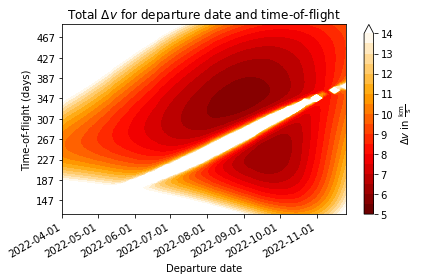

In [6]:
x = np.linspace(porkchop["dt1"], porkchop["dt2"], porkchop["num_values"], endpoint=False)
y = np.linspace(porkchop["tof1"], porkchop["tof2"], porkchop["num_values"], endpoint=False)
x = [sp.et2datetime(_t).date() for _t in x]
y /= 24 * 3600
X, Y = np.meshgrid(x, y)
X = X.T
Y = Y.T
Z = porkchop["values"].reshape((porkchop["num_values"], porkchop["num_values"])) / 1000

# Plot porkchop
plt.figure()
plt.title(r"Total $\Delta v$ for departure date and time-of-flight")
plt.xlabel("Departure date")
plt.ylabel("Time-of-flight (days)")
plt.gca().get_xaxis().set_major_formatter(pltdates.DateFormatter('%Y-%m-%d'))
plt.gca().get_yaxis().set_major_locator(pltdates.DayLocator(interval=40))
plt.gcf().autofmt_xdate()
lvls = plt.contourf(X, Y, Z, levels=np.linspace(5, 14, 19), cmap=pltcolors.LinearSegmentedColormap.from_list("", ["#600000","red","orange", "white"]), extend='max')
clbr = plt.colorbar(lvls, ax=plt.gca())
clbr.set_label(label=r"$\Delta v$ in $\mathrm{\frac{km}{s}}$")
plt.tight_layout()
plt.savefig("../out/plot.svg")
plt.savefig("../out/plot.png", dpi=300)

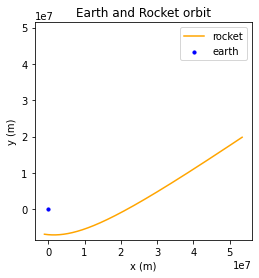

In [7]:
# plot earth-rocket inject orbit
rx_earth = (rocket["x"] - earth["x"])[:500000]
ry_earth = (rocket["y"] - earth["y"])[:500000]
rz_earth = (rocket["z"] - earth["z"])[:500000]
rx_earth, ry_earth = project(rx_earth, ry_earth, rz_earth, np.array([1, 0, 0]), n_earth)

plt.figure()
plt.title("Earth and Rocket orbit")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(rx_earth, ry_earth, ms=5, color='orange', label='rocket')
plt.scatter(np.array(0), np.array(0), s=10, color='blue', label='earth')

#plt.xlim(-1e7, 5e7)
#plt.ylim(-1e7, 5e7)
locx = plticker.MultipleLocator(base=1e7)
locy = plticker.MultipleLocator(base=1e7)
plt.gca().get_xaxis().set_major_locator(locx)
plt.gca().get_yaxis().set_major_locator(locy)
plt.axis('square')

plt.legend()
plt.savefig('../out/inject-orbit.png', dpi=100)
plt.show()

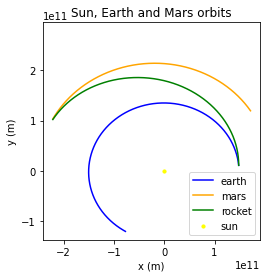

In [8]:
# plot sun-earth-mars orbit
plt.figure()
plt.title("Sun, Earth and Mars orbits")
plt.xlabel("x (m)")
plt.ylabel("y (m)")

t1 = 4000000
plt.plot(earth["x"][:t1], earth["y"][:t1], ms=5, color='blue', label='earth')
plt.plot(mars["x"][:t1], mars["y"][:t1], ms=5, color='orange', label='mars')
plt.plot(rocket["x"][:t1], rocket["y"][:t1], ms=5, color='green', label='rocket')
plt.scatter(np.array(0), np.array(0), s=10, color='yellow', label='sun')

#plt.xlim(-2.5e11, 2.5e11)
#plt.ylim(-2.5e11, 2.5e11)
locx = plticker.MultipleLocator(base=1e11)
locy = plticker.MultipleLocator(base=1e11)
plt.gca().get_xaxis().set_major_locator(locx)
plt.gca().get_yaxis().set_major_locator(locy)
plt.axis('square')
plt.legend()
plt.savefig('../out/transfer-orbit.png', dpi=100)
plt.show()

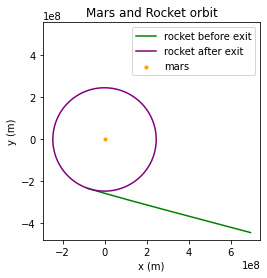

In [9]:
# plot mars-rocket exit orbit
exit_index = -1010000
rx_mars_1 = (rocket["x"] - mars["x"])[-1050000:exit_index]
ry_mars_1 = (rocket["y"] - mars["y"])[-1050000:exit_index]
rz_mars_1 = (rocket["z"] - mars["z"])[-1050000:exit_index]
rx_mars_1, ry_mars_1 = project(rx_mars_1, ry_mars_1, rz_mars_1, np.array([1, 0, 0]), n_mars)

rx_mars_2 = (rocket["x"] - mars["x"])[exit_index:-590000]
ry_mars_2 = (rocket["y"] - mars["y"])[exit_index:-590000]
rz_mars_2 = (rocket["z"] - mars["z"])[exit_index:-590000]
rx_mars_2, ry_mars_2 = project(rx_mars_2, ry_mars_2, rz_mars_2, np.array([1, 0, 0]), n_mars)

plt.figure()
plt.title("Mars and Rocket orbit")
plt.xlabel("x (m)")
plt.ylabel("y (m)")
plt.plot(rx_mars_1, ry_mars_1, ms=5, color='green', label='rocket before exit')
plt.plot(rx_mars_2, ry_mars_2, ms=5, color='purple', label='rocket after exit')
plt.scatter(np.array(0), np.array(0), s=10, color='orange', label='mars')

#plt.xlim(-3e8, 8e8)
#plt.ylim(-5e8, 3e8)
locx = plticker.MultipleLocator(base=2e8)
locy = plticker.MultipleLocator(base=2e8)
plt.gca().get_xaxis().set_major_locator(locx)
plt.gca().get_yaxis().set_major_locator(locy)
plt.axis('square')

plt.legend()
plt.savefig('../out/exit-orbit.png', dpi=100)
plt.show()